Import libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

from scipy.stats.stats import pearsonr 
from statistics import median
import statsmodels.api as sm 
import statistics
import seaborn as sns 

import pandas as pd
import numpy as np

import quandl
import datetime
import pandas_datareader as web
from sklearn.metrics import classification_report
import tqdm

from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from functools import reduce
import matplotlib as mpl

import statsmodels.formula.api as smf
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics

Using TensorFlow backend.


Parameters:

In [151]:
# start and end dates
start_date = datetime.datetime(2000,1,1)
end_date = datetime.datetime(2020,4,29)

# list of assets
asset_list = ['IYR']

# ACF parameters
acf_split = 5

# EMA parameters
ema_str = 6
ema_end = 12

CDFs:

In [152]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def check(lst, val): 
    return(all(x < val for x in lst))

def auc_roc(y_true, y_pred):
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
    
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def product(*args):
    if not args:
        return iter(((),)) 
    return (items + (item,) 
            for items in product(*args[:-1]) for item in args[-1])

def timeseries_train_test_split(X, y, test_size):
   
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def model_stat(z, x, y):
    for i in ['f1', 'roc_auc', 'precision', 'recall']:
        cv_results = cross_val_score(z, x, y, cv=kfold, scoring=i)
        print('---------------------------------------')
        print(i.upper())
        print('Mean:', (round(100*cv_results.mean())), '%')
        print('Std:', (round(100*cv_results.std())), '%')
        ('---------------------------------------')

### Data preparation

Read Adj.Close through Yahoo Finance:

In [153]:
df_list = []

for i in range(len(asset_list)):
    df_list.append(web.get_data_yahoo(asset_list[i], start=start_date, end=end_date)[['Adj Close']])

df = reduce(lambda left,right: pd.merge(left, right, on=['Date'], how='inner'), df_list)
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='M'))

print('Number of records:', len(df))
print('Start date:', str(df.index[0])[:11])
print('End date:', str(df.index[-1])[:11])

df = df.dropna(how='any', axis=0)
df.columns = asset_list
df.head()

Number of records: 238
Start date: 2000-06-30 
End date: 2020-03-31 


,IYR
2000-06-30,15.079794
2000-07-31,16.037428
2000-08-31,15.795547
2000-10-31,15.365685
2000-11-30,15.681485


### Exploratory analysis

Autocorr analysis - mean reversion period:

[]

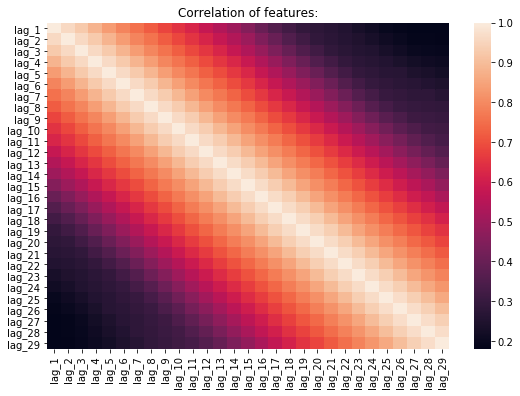

In [154]:
data = pd.DataFrame(df[asset_list[0]].copy())
data.columns = ['y']

for i in range(1, 30):
    data['lag_{}'.format(i)] = data.y.shift(i)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(X_train.corr())
plt.title('Correlation of features:')
plt.plot()

### ML: data preparation

Prepare features:

In [258]:
ema_str = 3
ema_end = 12

df_list = []

for i in range(len(asset_list)):
    df_list.append(web.get_data_yahoo(asset_list[i], start=start_date, end=end_date)[['Adj Close']])

df = reduce(lambda left,right: pd.merge(left, right, on=['Date'], how='inner'), df_list)
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='M'))
df = df.dropna(how='any', axis=0)
df.columns = asset_list

x = df.columns[0]

for i in range(ema_str, ema_end+1):
    df['EMA'+str(i)] = df[x].ewm(span=i).mean()
    
for i in range(ema_str, ema_end+1):
    df['dMA'+str(i)] = (df['EMA'+str(i)] - df['EMA'+str(i)].shift())/df['EMA'+str(i)]

df['Return'] = df['Ret'] = (df[x] - df[x].shift())/df[x].shift()
df['Target'] = (df['Return'] > 0).shift(-1, axis = 0)
df['TargetR'] = df['Return'].shift(-1, axis = 0)
    
df.dropna(inplace=True)
df.iloc[:, :5].head()

,IYR,EMA3,EMA4,EMA5,EMA6
2000-07-31,16.037428,15.718217,15.678315,15.654374,15.638414
2000-08-31,15.795547,15.762405,15.738127,15.721245,15.709051
2000-10-31,15.365685,15.550821,15.566968,15.573551,15.576422
2000-11-30,15.681485,15.618261,15.616637,15.614986,15.613297
2001-01-31,16.842295,16.239992,16.130893,16.063461,16.018216


Prepare synthetic features - price target:

In [259]:
X = df.filter(regex='dMA')
Y = df['Target'].astype(int).values
Yr = df['TargetR'].astype(float).values 

x,y = RandomUnderSampler(sampling_strategy='majority').fit_resample(X, Y)

### ML: classification

Dummy classifier:

In [260]:
model = DummyClassifier(random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=1)
model_stat(model,X,Y)

---------------------------------------
F1
Mean: 65.0 %
Std: 4.0 %
---------------------------------------
ROC_AUC
Mean: 49.0 %
Std: 5.0 %
---------------------------------------
PRECISION
Mean: 65.0 %
Std: 4.0 %
---------------------------------------
RECALL
Mean: 66.0 %
Std: 4.0 %


LogReg classifier:

In [261]:
model = LogisticRegression(fit_intercept=False, verbose=0, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model_stat(model,X,Y)

---------------------------------------
F1
Mean: 68.0 %
Std: 4.0 %
---------------------------------------
ROC_AUC
Mean: 46.0 %
Std: 8.0 %
---------------------------------------
PRECISION
Mean: 63.0 %
Std: 4.0 %
---------------------------------------
RECALL
Mean: 73.0 %
Std: 5.0 %


Model factors:

In [262]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7)
clf = model.fit(X_train, Y_train)
z = list(clf.coef_[0])

print('Intercept:', np.round(clf.intercept_[0],2))
print('Coefficients:', [np.round(i,2) for i in z])

Intercept: 0.0
Coefficients: [-0.02, 0.0, 0.02, 0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.05]


### Model backtest

Prepare data:

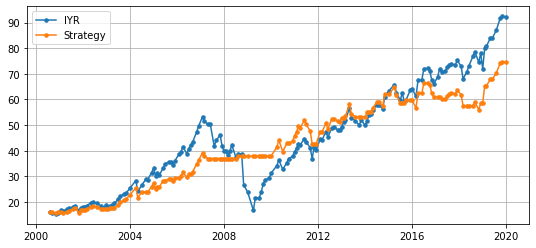

In [263]:
ema_str = 3
ema_end = 12

df_list = []

for i in range(len(asset_list)):
    df_list.append(web.get_data_yahoo(asset_list[i], start=start_date, end=end_date)[['Adj Close']])

df = reduce(lambda left,right: pd.merge(left, right, on=['Date'], how='inner'), df_list)
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='M'))
df = df.dropna(how='any', axis=0)
df.columns = asset_list

x = df.columns[0]

for i in range(ema_str, ema_end+1):
    df['EMA'+str(i)] = df[x].ewm(span=i).mean()
    
for i in range(ema_str, ema_end+1):
    df['dMA'+str(i)] = (df['EMA'+str(i)] - df['EMA'+str(i)].shift())/df['EMA'+str(i)]

df['Return'] = df['Ret'] = (df[x] - df[x].shift())/df[x].shift()
df['Target'] = (df['Return'] > 0).shift(-1, axis = 0)
df['TargetR'] = df['Return'].shift(-1, axis = 0)
    
df.dropna(inplace=True)

Position = []
trades = 0

for i in range(0, df.shape[0]):
    if min(df.filter(regex='dMA').iloc[i])>0:
        Position.append('Long')
    else:
        Position.append('Cash')
        trades = trades +1

df['Position'] = Position

LongShort = [0]*df[x].shape[0]
LongShort[0] = df[x].iloc[0] 
LongShort[1] = df[x].iloc[0]

pos_dur = []
dur = 0
 
for i in range(0, df[x].shape[0]-2):
    if df['Position'].iloc[i] == 'Long':
        LongShort[i+2] = LongShort[i+1] + LongShort[i+1]*df['Return'][i+2]
        dur = dur +1
    else:
        LongShort[i+2] = LongShort[i+1]
        pos_dur.append(dur)
        dur = 0
        
pos_dur = [x for x in pos_dur if x > 0]
df['LongHold'] = LongShort
df.drop(df.tail(1).index,inplace=True)

fig = plt.figure(figsize=(9,4))
plt.plot(df[x], '.-',  markersize=7, label=asset_list[0])
plt.plot(df['LongHold'], '.-',  markersize=7, label='Strategy')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Strategy performance:

In [264]:
df['Lh_Ret'] = (df['LongHold'] - df['LongHold'].shift())/df['LongHold'].shift()
ls_cum = int(round(100*(df['LongHold'][-1] - df['LongHold'][0])/df['LongHold'][0]))
bench_cum = int(round(100*(df[x][-1] - df[x][0])/df[x][0]))

bench_ann = int(round(100*((df[x][-1]/df[x][0])**(1/int(df.index[-1].year - df.index[0].year))-1)))
ls_ann = int(round(100*((df['LongHold'][-1]/df['LongHold'][0])**(1/int(df.index[-1].year - df.index[0].year))-1))) 

df.dropna(inplace=True)

print('\nBenchmark cumulated return:', bench_cum, '%') 
print('Strategy cumulated return:', ls_cum, '%') 

print('\nBenchmark Sharpe:', round(np.mean(df['Return'])/np.std(df['Return']),2)) 
print('Strategy Sharpe:', round(np.mean(df['Lh_Ret'])/np.std(df['Lh_Ret']),2)) 

print('\nBenchmark Var(0.95, 1m):', int(round(100*np.quantile(([abs(x) for x in df['Return'] if x <= 0]), 0.95))), '%')
print('Strategy Var(0.95, 1m):', int(round(100*np.quantile(([abs(x) for x in df['Lh_Ret'] if x <= 0]), 0.95))), '%')

print('\nPosition median duration:', int(round(np.median(pos_dur))),'m')
print('Trades per year:', int(round(trades/(df.index[-1].year - df.index[0].year))))

print('\nBenchmark vice strategy corr:', int(round(100*(pearsonr(list(df['Return']),list(df['Lh_Ret']))[0]))), '%') 


Benchmark cumulated return: 475 %
Strategy cumulated return: 365 %

Benchmark Sharpe: 0.19
Strategy Sharpe: 0.24

Benchmark Var(0.95, 1m): 15 %
Strategy Var(0.95, 1m): 7 %

Position median duration: 4 m
Trades per year: 3

Benchmark vice strategy corr: 62 %
